In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,10)})

In [3]:
year = '19'

In [4]:
data = pd.read_csv('../outputs/'+year+'/out'+year+'.csv', index_col='Unnamed: 0')
triggers = pd.read_csv('../outputs/'+year+'/triggers'+year+'.csv', index_col='label')
reg_eff = pd.read_csv('../outputs/model/outmodel.csv', index_col='Unnamed: 0')

In [20]:
data.head()

,dEmin,dEmax,Emean,CS,dCS
537.5,0.0,0.0,537.45,6.251548,0.210861
550.0,0.0,0.0,549.34,3.630851,0.136161
562.5,0.0,0.0,562.50,2.456529,0.118424
575.0,0.0,0.0,574.86,1.889751,0.102003
587.5,0.0,0.0,587.73,1.188691,0.073576


In [6]:
triggers.head()

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
label,,,,,,,,,
537.5,453.0,20.0,1549.0,0.99,0.77,1.00,0.00,0.01,0.0
550.0,312.0,17.0,1076.0,0.98,0.77,1.00,0.00,0.01,0.0
562.5,171.0,9.0,507.0,0.98,0.75,1.00,0.01,0.02,0.0
575.0,64.0,19.0,442.0,0.96,0.87,0.99,0.01,0.01,0.0
587.5,32.0,10.0,346.0,0.97,0.91,1.00,0.01,0.01,0.0


In [7]:
reg_eff.head()

,Nsig,dNsig,lum,dEmin,dEmax,Emean
550.0,1800.36,44.01,7163,0.0,0.0,550.0
562.5,1573.35,41.42,6306,0.0,0.0,562.5
575.0,1374.38,38.87,5516,0.0,0.0,575.0
587.5,1311.21,37.58,5116,0.0,0.0,587.5
600.0,1134.09,35.69,4606,0.0,0.0,600.0


Get N/L

In [8]:
data['CSvis'] = data['Nsig']/data['lum']
data['dCSvis'] = data['dNsig']/data['lum']

Trigger join

In [9]:
data = data.join(triggers[['TrigEff', 'TrigErr']], how='left')

In [10]:
data = data.drop(['Nsig', 'dNsig', 'lum'], axis=1)

Get Reg_eff

In [11]:
reg_eff['RegEff'] = reg_eff['Nsig']/reg_eff['lum']
reg_eff['RegErr'] = reg_eff['dNsig']/reg_eff['lum']
reg_eff.drop(['dEmax', 'dEmin', 'lum', 'Nsig', 'dNsig'], axis=1, inplace=True)

Reg eff join

In [12]:
data['RegEff'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegEff), axis=1)
data['RegErr'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegErr), axis=1)

Recalc cross section

In [13]:
data['CS'] = data['CSvis']/data['TrigEff']/data['RegEff'];
data['dCS'] = data['CS']*np.sqrt( np.square( data['dCSvis']/data['CSvis'] ) + 
                                np.square( data['TrigErr']/data['TrigEff'] ) + 
                                np.square( data['RegErr']/data['RegEff'] ))

In [14]:
data.drop(['CSvis', 'dCSvis', 'TrigEff', 'TrigErr', 'RegEff', 'RegErr'], axis=1, inplace=True)

In [15]:
data.to_csv('../outputs/'+year+'/result_new.csv')

## Draw cross sections

In [21]:
cs11 = pd.read_csv('../outputs/11/result_new.csv', index_col=['Unnamed: 0'])
cs12 = pd.read_csv('../outputs/12/result_new.csv', index_col=['Unnamed: 0'])
cs17 = pd.read_csv('../outputs/17/result_new.csv', index_col=['Unnamed: 0'])
cs19 = pd.read_csv('../outputs/19/result_new.csv', index_col=['Unnamed: 0'])

In [22]:
radcor = pd.read_csv('rad_cors.dat', delimiter='\t', names=['energy', 'radcor'], index_col=['energy'])

In [23]:
cs19.tail()

,dEmin,dEmax,Emean,CS,dCS
950.0,0.0,0.0,950.15,0.047140,0.016132
955.0,0.0,0.0,956.05,0.050070,0.019491
962.5,0.0,0.0,962.82,0.075411,0.016251
975.0,0.0,0.0,976.21,0.005804,0.003662
987.5,0.0,0.0,987.80,0.087324,0.017234


In [24]:
radcor.head()

,radcor
energy,
525.0,0.863528
540.0,0.861685
550.0,0.867511
562.5,0.874765
575.0,0.881186


In [25]:
cs11['rad'] = np.interp(cs11.Emean, radcor.index, radcor.radcor)
cs12['rad'] = np.interp(cs12.Emean, radcor.index, radcor.radcor)
cs17['rad'] = np.interp(cs17.Emean, radcor.index, radcor.radcor)
cs19['rad'] = np.interp(cs19.Emean, radcor.index, radcor.radcor)

In [26]:
def born(data):
    data['born'] = data.CS/data.rad
    data['born_err'] = data.dCS/data.rad

In [27]:
born(cs11)
born(cs12)
born(cs17)
born(cs19)

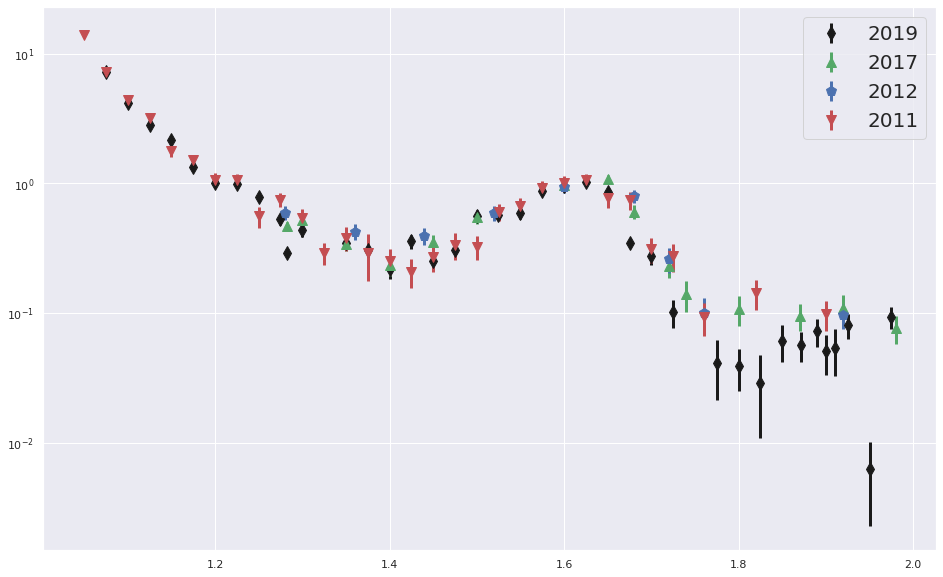

In [28]:
plt.errorbar(cs19.index*2e-3, cs19.born, yerr=cs19.born_err, fmt='kd', elinewidth=3, ms=10, label='2019')
plt.errorbar(cs17.index*2e-3, cs17.born, yerr=cs17.born_err, fmt='g^', elinewidth=3, ms=10, label='2017')
plt.errorbar(cs12.index*2e-3, cs12.born, yerr=cs12.born_err, fmt='bp', elinewidth=3, ms=10, label='2012')
plt.errorbar(cs11.index*2e-3, cs11.born, yerr=cs11.born_err, fmt='rv', elinewidth=3, ms=10, label='2011')
plt.yscale('log')
ax = plt.gca()
ax.legend(fontsize=20)
#plt.savefig('cs.svg')